In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
titanic_data = pd.read_csv(r'C:\Users\ThinkPad\Documents\DS Project\train (4).csv')

In [9]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


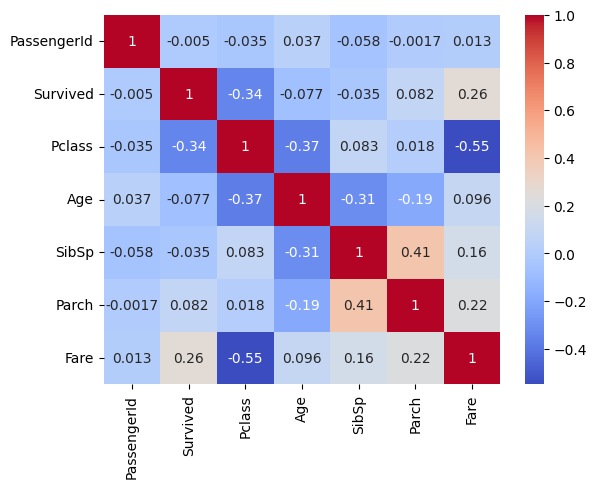

In [10]:
import seaborn as sns

sns.heatmap(titanic_data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices, test_indices in split.split(titanic_data, titanic_data[['Survived', 'Pclass', 'Sex']]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

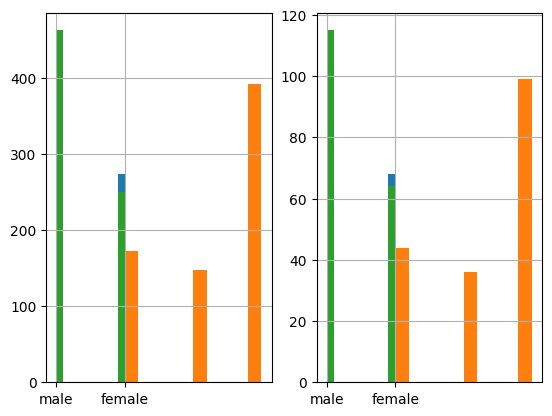

In [12]:
plt.subplot(1, 2, 1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()
strat_train_set['Sex'].hist()

plt.subplot(1, 2, 2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()
strat_test_set['Sex'].hist()
plt.show()

In [13]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          565 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        167 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy='median')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [15]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()

        column_names = ['C', 'Q', 'S', 'N']

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]).toarray()

        column_names = ['Female', 'Male']

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X


In [16]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(['Embarked', 'Name', 'Ticket', 'Cabin', 'Sex', 'N'], axis=1, errors='ignore')

In [17]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('age_imputer', AgeImputer()),
    ('feature_encoder', FeatureEncoder()),
    ('feature_dropper', FeatureDropper())
])

In [18]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [19]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop('Survived', axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [500, 600, 700],
    'max_depth': [None],
    'min_samples_split': [3]
}

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'min_samples_split': [3],
                         'n_estimators': [500, 600, 700]},
             return_train_score=True, scoring='accuracy')

In [21]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(min_samples_split=3, n_estimators=700, random_state=42)

In [22]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [23]:
X_test = strat_test_set.drop('Survived', axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_test_data = scaler.fit_transform(X_test)
y_test_data = y_test.to_numpy()

In [24]:
final_clf.score(X_test_data, y_test_data)

0.8268156424581006

In [25]:
final_data = pipeline.fit_transform(titanic_data)

In [26]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,Female,Male
0,1,0,3,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.0,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,28.0,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.0,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [27]:
X_final = final_data.drop('Survived', axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_final_data = scaler.fit_transform(X_final)
y_final_data = y_final.to_numpy()

In [28]:
prod_clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [200, 500, 600],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2,3,4]
}

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_final_data, y_final_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [200, 500, 600]},
             return_train_score=True, scoring='accuracy')

In [29]:
prod_final_clf = grid_search.best_estimator_
prod_final_clf

RandomForestClassifier(max_depth=5, n_estimators=600, random_state=42)

In [30]:
titanic_test_data = pd.read_csv(r'C:\Users\ThinkPad\Documents\DS Project\test (2).csv')

In [31]:
final_test_data = pipeline.fit_transform(titanic_test_data)
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,Q,S,Female,Male
0,892,3,34.5,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.0,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.0,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,27.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.0,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.5,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,27.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [32]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   Q            418 non-null    float64
 8   S            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.1 KB


In [33]:
X_final_test = final_test_data

In [34]:
X_final_test = X_final_test.fillna(method='ffill')

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final_test)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_24552\1295809361.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method='ffill')


In [35]:
predictions = prod_final_clf.predict(X_data_final)

In [36]:
final_df = pd.DataFrame({
    'PassengerId': titanic_test_data['PassengerId'],
    'Survived': predictions
})

In [37]:
final_df.to_csv(r'C:\Users\ThinkPad\Documents\DS Project\submission.csv', index=False)